In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GRU
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import time

In [2]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

### 读取股票文件

In [3]:
zhongshihua = pd.read_csv('./SH600028.csv')  

In [4]:
zhongshihua

,Unnamed: 0,date,open,close,high,low,volume,code
0,0,2005-01-04,2.070,2.008,2.070,1.903,204927.00,600028
1,1,2005-01-05,2.008,1.979,2.008,1.965,205665.95,600028
2,2,2005-01-06,1.979,1.951,1.993,1.917,158663.61,600028
3,3,2005-01-07,1.955,1.993,2.036,1.951,91314.65,600028
4,4,2005-01-10,1.984,1.970,1.989,1.946,73510.45,600028
...,...,...,...,...,...,...,...,...
4028,4028,2021-10-11,4.610,4.620,4.670,4.560,2429407.00,600028
4029,4029,2021-10-12,4.590,4.510,4.650,4.460,2418625.00,600028
4030,4030,2021-10-13,4.470,4.330,4.480,4.290,3198332.00,600028
4031,4031,2021-10-14,4.330,4.340,4.380,4.290,1294875.00,600028


### 用开盘数据做

In [5]:
test_num=260

In [6]:
training_set = zhongshihua.iloc[0:len(zhongshihua) - test_num, 2:3].values#第2列是开盘价格
test_set = zhongshihua.iloc[len(zhongshihua) - test_num:, 2:3].values

### 归一化处理（提高准确性）$x^*=\frac{X-X_{min}}{X_{max}-X_{min}}$

In [7]:
sc = MinMaxScaler(feature_range=(0, 1))  #用MinMaxScaler类进行最简单的归一化
training_set_scaled = sc.fit_transform(training_set)
test_set = sc.transform(test_set)

### 创建训练集和测试集

In [8]:
x_train = []
y_train = []
x_test = []
y_test = []

In [9]:
longlonglong=60

In [10]:
for i in range(longlonglong, len(training_set_scaled)):  #从归一化的数据中取出带训练的数据，x为前60天数据，标签y为今天数据
    x_train.append(training_set_scaled[i - longlonglong:i, 0])
    y_train.append(training_set_scaled[i, 0])

In [11]:
np.random.seed(7)#乱序
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)

### 丢入RNN

In [13]:
x_train = np.reshape(x_train, (x_train.shape[0], longlonglong, 1))#重塑为rnn能读取的格式，60：每组有60个x，1：1次放进的参数x是一维的

In [14]:
for i in range(longlonglong, len(test_set)):    #取出测试数据
    x_test.append(test_set[i - longlonglong:i, 0])
    y_test.append(test_set[i, 0])

In [15]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], longlonglong, 1))

### 两次GRU，D=0.2

In [16]:
#第一层GRU：80个单元，每次返回ht参数
#第二层GRU：100个单元，仅在最后一次返回ht参数
#Dropout：每次令其中20%的单元休眠
#Dense（1）：最后一层全链接层进行输出
model = tf.keras.Sequential([   
    GRU(40, return_sequences=True),
    Dropout(0.2),
    GRU(80),
    Dropout(0.2),
    Dense(1)
])

### loss用均方误差

In [17]:
#使用Adam优化器，初始学习率为0.001
#loss函数使用均方误差
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')

### 建立checkpoint

In [18]:
checkpoint_save_path = "./checkpoint/stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('载入已有模型')
    model.load_weights(checkpoint_save_path)

载入已有模型


In [19]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
#                                                  save_weights_only=True,
#                                                  save_best_only=True,
#                                                  monitor='val_loss')
# #开始训练，batch size为32，一共跑50轮，每一轮都验证一次
# history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), validation_freq=1,
#                     callbacks=[cp_callback])

### 储存权重

In [20]:
# file = open('./weights.txt', 'w') 
# for v in model.trainable_variables:
#     file.write(str(v.name) + '\n')
#     file.write(str(v.shape) + '\n')
#     file.write(str(v.numpy()) + '\n')
# file.close()

### 反归一化 $x^*=\frac{X-X_{min}}{X_{max}-X_{min}}$

In [21]:
#在模型中放入测试数据
predicted_stock_price = model.predict(x_test)
#对结果进行反归一化
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
real_stock_price = sc.inverse_transform(test_set[longlonglong:])

### 500个对照

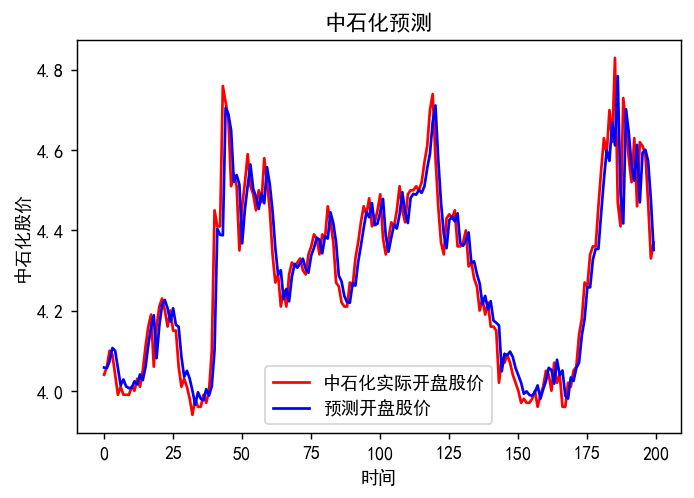

In [22]:
plt.figure(dpi=130)
plt.plot(real_stock_price, color='red', label='中石化实际开盘股价')
plt.plot(predicted_stock_price, color='blue', label='预测开盘股价')
plt.title('中石化预测')
plt.xlabel('时间')
plt.ylabel('中石化股价')
plt.legend()
plt.show()

### 2021年10月16日开盘为 4.37

In [23]:
pre=zhongshihua.iloc[len(zhongshihua) - longlonglong-1:, 2:3].values
pre = sc.transform(pre)
pred=[]
pre=np.array(pre)
for i in range(longlonglong, len(pre)):
    pred.append(pre[i - longlonglong:i, 0])
pred=np.array(pred)
pred=np.reshape(pred,(pred.shape[0],longlonglong,1))
predicted_stock_price = model.predict(pred)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print('预测开盘股价为:',predicted_stock_price[0][0],',偏差值:',(predicted_stock_price[0][0]-4.37)/4.37*100,'%')

预测开盘股价为: 4.351029 ,偏差值: -0.4341208416482701 %


In [24]:
def rSquare(X,Y):
    XMean = np.mean(X)
    YMean = np.mean(Y)
    #标准差
    XSD = np.std(X)
    YSD = np.std(Y)
    #z分数
    ZX = (X-XMean)/XSD
    ZY = (Y-YMean)/YSD
    #相关系数
    r = np.sum(ZX*ZY)/(len(X))
    return r

In [25]:
time_100=[]
for i in range(100):
    d1=time.time()*1000

    #在模型中放入测试数据
    predicted_stock_price = model.predict(x_test)
    #对结果进行反归一化
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    real_stock_price = sc.inverse_transform(test_set[longlonglong:])
    predicted_stock_price_1=[]
    real_stock_price_1=[]

    for i,j in zip(predicted_stock_price,real_stock_price):
        predicted_stock_price_1.append(i[0])
        real_stock_price_1.append(j[0])

    d2=time.time()*1000
    time_100.append(d2-d1)

print('运行时间：',str(np.mean(time_100)),'ms')
print('确定系数：',rSquare(predicted_stock_price_1,real_stock_price_1))

运行时间： 61.27838623046875 ms
确定系数： 0.9376084104636034


In [26]:
r=rSquare(predicted_stock_price_1,real_stock_price_1)
t=np.mean(time_100)
(r*10+t)/(r*t)

1.2297330099978565